In [20]:
# Resetando os dados da execução
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [21]:
# Monstando o Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Importando TensonFlow e outras bibliotecas

In [22]:
!pip install tensorflow
!pip install matplotlib
!pip install numpy
!pip install os-sys
!pip install Pillow

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

  Using cached os_sys-2.1.4-py3-none-any.whl (15.6 MB)
  Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
  Using cached progressbar-2.5.tar.gz (10 kB)
  Using cached pyinstaller-4.9-py3-none-manylinux2014_x86_64.whl (1.5 MB)
  Using cached pypiwin32-223-py3-none-any.whl (1.7 kB)
  Using cached WMI-1.5.1-py2.py3-none-any.whl (28 kB)
  Using cached cefpython3-66.0-py2.py3-none-manylinux1_x86_64.whl (79.6 MB)
     |████████████████████████████████| 11.7 MB 4.5 MB/s eta 0:00:01
  Using cached SQLAlchemy-1.3.24-cp39-cp39-manylinux2010_x86_64.whl (1.3 MB)
     |████████████████████████████████| 296 kB 124.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.9 MB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 12.3 MB/s eta 0:00:011
     |████████████████████████████████| 5.8 MB 40.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata .

## Baixando e explorando o conjunto de dados


In [23]:
# O conjunto de dados contém cinco subdiretórios, um por classe
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [24]:
# Printando a quantidade das imagens
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'São {image_count} imagens')

São 3670 imagens


Alguns exemplos de rosas:

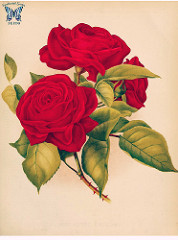

In [25]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

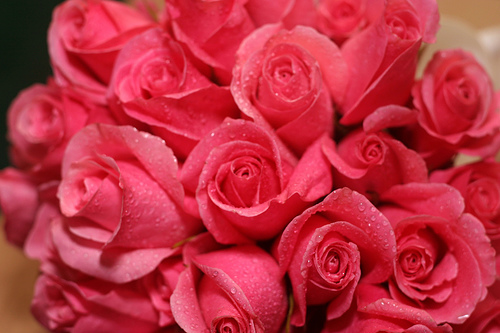

In [26]:
PIL.Image.open(str(roses[1]))

Alguns exemplos de tulipas

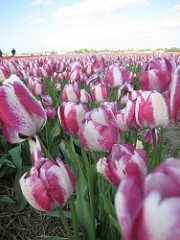

In [27]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

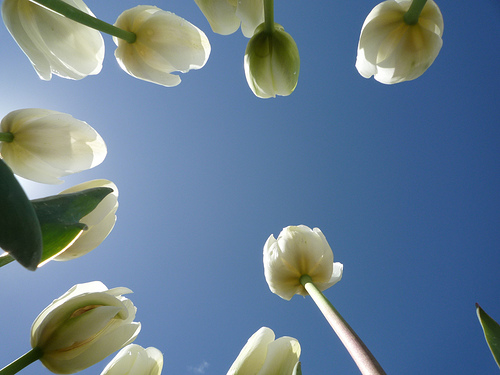

In [28]:
PIL.Image.open(str(tulips[1]))

### Criando um conjunto de dados
Definindo alguns parâmetros para o carregador:

In [29]:
batch_size = 32
img_height, img_width = 180, 180

80% das imagens para treinamento e 20% para validação.

In [30]:
# Vamos usar 80% das imagens para treinamento e 20% para validação.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


O atributo `class_name` do conjunto de dados `data_dir` tem o nome da classes, que correspondem aos nomes dos diretórios em ordem alfabética.

In [32]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualizando os dados
Mostrando as primeiras 9 imagens do conjunto de dados de treino

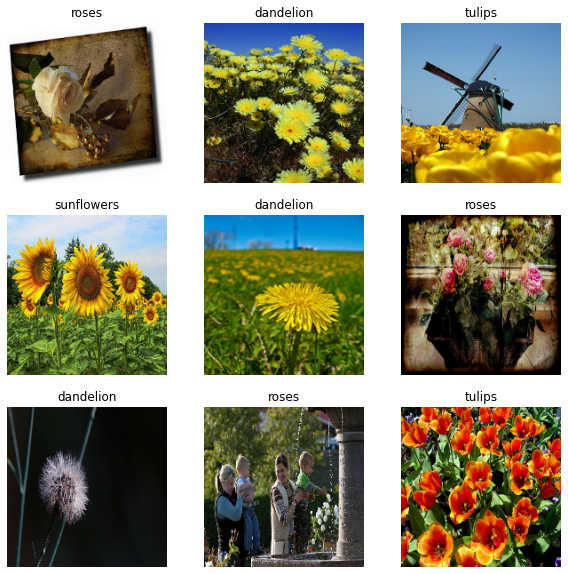

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


O `image_batch` é um tensor da forma `(32, 180, 180, 3)`. Este é um lote de **32 imagens** de forma `180x180x3` (a última dimensão refere-se aos canais de cores RGB). O `label_batch` é um tensor da forma `(32,)`, estes são rótulos correspondentes às **32 imagens**.

### Configurando o conjunto de dados para desempenho

Vamos nos certificar de usar a pré-busca em buffer para produzir dados do disco sem que a E/S se torne um bloqueio. Estes são dois métodos importantes ao carregar dados:

*   `Dataset.cach`: mantém as imagens na memória após serem carregadas no disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo ao treinar seu modelo. Se o conjunto de dados for muito grande para caber na memória, também pode-se usar esse método para criar um cache em disco de alto desempenho.
*   `Dataset.prefetch`: sobrepõe o pré-processamento de dados e a execução do modelo durante o treinamento.







In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalizando os dados

Os valores do canal RGB estão no intervalo `[0, 255]`. O ideal é tornar os valores de entrada pequenos.

Usando `tf.keras.layers.Rescaling`, normalizaremos os valores para estarem no intervalo `[0, 1]`:

In [36]:
normalization_layer = Rescaling(1./255)

Existem duas maneiras de usar essa camada. Aplicá-lo ao conjunto de dados chamando `Dataset.map` ou incluir a camada dentro da definição do seu modelo, o que pode simplificar a implantação.

## Criando o modelo

O modelo **Sequential** consiste em três blocos de convolução (`tf.keras.layers.Conv2D`) com uma camada max pooling (`tf.keras.layers.MaxPooling2D`) em cada um delas. Há uma camada totalmente conectada (`tf.keras.layers.Dense`) com **128 unidades** em cima dela que é ativada por uma função de ativação ReLU (`'relu'`).

In [37]:
num_classes = len(class_names)

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

### Compilando o modelo

O otimizador usado é o `tf.keras.optimizers.Adam`
e a função de perda é `tf.keras.losses.SparseCategoricalCrossentropy`. 
Para visualizar a precisão de treinamento e validação para cada época de treinamento, passamos as métricas como argumento para `model.compile`.

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Sumário do modelo

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Treinando o modelo

In [4]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: name 'model' is not defined

## Visualizando os resultados do treinamento

Criamos gráficos de **perda** e **precisão** nos conjuntos de treinamento e validação:

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

A precisão do treinamento e a precisão da validação estão com grandes margens, e o modelo alcançou apenas cerca de 60% de precisão no conjunto de validação.

Vamos inspecionar o que deu errado e tentar aumentar o desempenho geral do modelo.

### Overfitting
A precisão do treinamento está aumentando linearmente ao longo do tempo, enquanto a precisão da validação fica em torno de 60% no processo de treinamento, o que indica overfitting.

Quando há um pequeno número de exemplos de treinamento, o modelo às vezes aprende com ruídos ou detalhes indesejados de exemplos de treinamento, podendo impactar negativamente o desempenho do modelo em novos exemplos, é o que chamamos de overfitting. Isso significa que o modelo terá dificuldade em generalizar em um novo conjunto de dados.

Há algumas maneiras de combater o overfitting no processo de treinamento. Iremos testar:

*   Aumento de dados
*   Adicionar Dropout


### Aumento de Dados
O overfitting geralmente ocorre quando há um pequeno número de exemplos de treinamento. O aumento de dados adota a abordagem de gerar dados de treinamento adicionais de seus exemplos existentes, aumentando-os usando transformações aleatórias que produzem imagens de aparência crível. Isso ajuda a expor o modelo a mais aspectos dos dados e a generalizar melhor.

O aumento de dados será implementado usando as seguintes camadas de pré-processamento Keras: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` e `tf.keras.layers.RandomZoom`. Elas podem ser incluídas dentro do modelo como outras camadas e executadas na GPU.

In [40]:
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

Visualizando exemplos aumentados aplicando o aumento de dados à mesma imagem várias vezes:

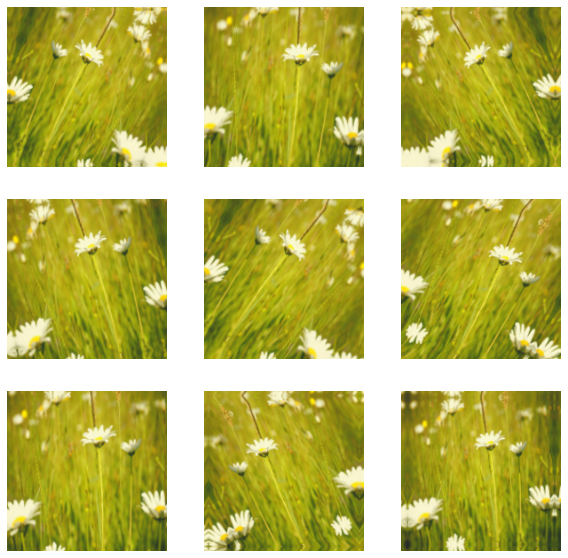

In [41]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

Quando se aplica dropout a uma camada, ela descarta aleatoriamente (definindo a ativação como zero) um número de unidades de saída da camada durante o processo de treinamento. Dropout recebe um número fracionário como valor de entrada, na forma de 0,1, 0,2, 0,4, etc. Isso significa descartar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

Vamos criar uma nova rede neural `tf.keras.layers.Dropout` antes de treiná-la usando as imagens aumentadas:

In [84]:
model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  Dropout(0.2),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

### Compilando e treinando o modelo

In [85]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 dropout_19 (Dropout)        (None, 180, 180, 16)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                     

In [87]:
epochs = 15
history = model.fit(
  train_ds,
  batch_size=128,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 7s 62ms/step - loss: 1.4203 - accuracy: 0.3597 - val_loss: 1.1760 - val_accuracy: 0.5504
Epoch 2/15
92/92 [==============================] - 5s 59ms/step - loss: 1.0915 - accuracy: 0.5661 - val_loss: 1.0888 - val_accuracy: 0.5804
Epoch 3/15
92/92 [==============================] - 5s 60ms/step - loss: 0.9980 - accuracy: 0.6202 - val_loss: 0.9805 - val_accuracy: 0.6076
Epoch 4/15
92/92 [==============================] - 5s 60ms/step - loss: 0.9280 - accuracy: 0.6434 - val_loss: 0.9268 - val_accuracy: 0.6444
Epoch 5/15
92/92 [==============================] - 5s 60ms/step - loss: 0.8782 - accuracy: 0.6614 - val_loss: 0.8473 - val_accuracy: 0.6771
Epoch 6/15
92/92 [==============================] - 5s 60ms/step - loss: 0.8081 - accuracy: 0.6873 - val_loss: 0.8266 - val_accuracy: 0.6812
Epoch 7/15
92/92 [==============================] - 5s 60ms/step - loss: 0.7741 - accuracy: 0.6975 - val_loss: 0.7767 - val_accuracy: 0.6975
Epoch 8/15
92

### Visualizando resultados do treinamento

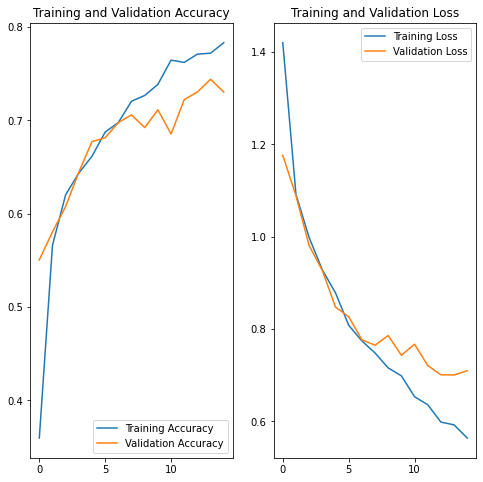

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Classificando novo dado

In [93]:
!pip install Pillow

In [99]:
!python3 -m pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


/usr/bin/sh: 1: sudo: not found


In [94]:
import PIL

In [107]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f'Esta imagem é uma {(class_names[np.argmax(score)]).upper()} com {100 * np.max(score):.2f}% de confiança.')

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

### Salvando o modelo

In [108]:
tf.keras.models.save_model(model,'flowers_model9.hdf5')

# Streamlit

In [109]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 41.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 63.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 KB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 KB 35.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pandas-1.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [110]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import cv2

@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/flowers_model9.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)


def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),   interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
        prediction = model.predict(img_reshape)
        
        return prediction


if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(predictions)
    st.write(score)
    print(f'Esta imagem é uma {(class_names[np.argmax(score)]).upper()} com {100 * np.max(score):.2f}% de confiança.')
    
    

Overwriting app.py


In [111]:
!pip install pyngrok

In [112]:
!ngrok authtoken 25q47GW3Apt6Sk02kFjnBdP8Vee_7ZDPtjYcWfdVZTN9YyNJ2

Authtoken saved to configuration file: /home/studio-lab-user/.ngrok2/ngrok.yml


In [113]:
!nohup streamlit run app.py &

OSError: Background processes not supported.

In [ ]:
from pyngrok import ngrok

url = ngrok.connect(port=8501)
url

In [56]:
!cat /content/nohup.out

2022-03-02 17:17:56.022 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.234.20.197:8501

2022-03-02 17:22:15.946 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://35.234.20.197:8502



### ALTERNATIVE DEPLOYMENT CODE

In [57]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2022-03-02 17:39:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  6.58MB/s    in 2.0s    

2022-03-02 17:39:48 (6.58 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [58]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [59]:
get_ipython().system_raw('./ngrok http 8501 &')

In [60]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'


2022-03-02 17:41:19.691 t=2022-03-02T17:41:19+0000 lvl=info msg=start pg=/api/tunnels id=7a6857cfa23aa5ec
2022-03-02 17:41:19.693 t=2022-03-02T17:41:19+0000 lvl=info msg=end pg=/api/tunnels id=7a6857cfa23aa5ec status=200 dur=196.159µs


Execute the next cell and the go to the following URL: https://4bb6-35-234-20-197.ngrok.io


In [ ]:
!streamlit run /content/app.py

2022-03-02 17:42:00.378 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8503
  External URL: http://35.234.20.197:8503



2022-03-02 17:42:32.271 t=2022-03-02T17:42:32+0000 lvl=warn msg="failed to open private leg" id=edd469cfd19f privaddr=localhost:80 err="dial tcp 127.0.0.1:80: connect: connection refused"
2022-03-02 17:42:34.578 t=2022-03-02T17:42:34+0000 lvl=warn msg="failed to open private leg" id=11081023c744 privaddr=localhost:80 err="dial tcp 127.0.0.1:80: connect: connection refused"
2022-03-02 17:43:06.546 t=2022-03-02T17:43:06+0000 lvl=warn msg="failed to open private leg" id=4f32133e753d privaddr=localhost:80 err="dial tcp 127.0.0.1:80: connect: connection refused"
2022-03-02 17:43:07.256 t=2022-03-02T17:43:07+0000 lvl=warn msg="failed to open private leg" id=87bf6a911d84 privaddr=localhost:80 err="dial tcp 127.0.0.1:80: connect: connection refused"


### Rodando o web app

In [46]:
!streamlit run /content/app.py

2022-03-02 16:53:59.709 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.234.20.197:8501

  Stopping...
  Stopping...


In [37]:
streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

SyntaxError: ignored

[Clique aqui nessa desgraça](https://www.tensorflow.org/tutorials/images/classification#overfitting)